<a href="https://colab.research.google.com/github/ltcolscotty/F101-img-classification-ai-v1/blob/main/2_0_Build_Pizzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer learning ML Project
[data set](https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html#torchvision.datasets.Food101) - expected to take a LOT of time to download due to sheer size of the data set

~64k images per epoch

#Build Version
7.0

#Considered loss functions:
- Cross Entropy Loss (Already incorporates NLL)
- Negative Log-Likeleyhood
- Kullback Liebler Divergence

#Learning Rates tested:
[Check the [loss rate tracking sheet](https://docs.google.com/spreadsheets/d/14ga3NkQNNMBBGRinW5uz0Z1gpkjMicNn1y9MxqF2Za4/edit?usp=sharing) for progress]

#To-Do list to optimize convergence
 - Testing adadelta grad and ams grad

#Current blocks
 - Finding best optimizer
 - Bigger batch seems to = Better results, but it also increases time to train and uses more vRAM, doesn't seem to be much of an issue as of right now

[View loss rate tracking here](https://docs.google.com/spreadsheets/d/14ga3NkQNNMBBGRinW5uz0Z1gpkjMicNn1y9MxqF2Za4/edit?usp=sharing)

#Importing (Universal)
Basic package importing, setting compute device to use the cuda cores on the gpu

In [ ]:
import time, copy, enum

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

import torch.optim as optim
from torch.optim import lr_scheduler

from torchsummary import summary

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

device = "cuda" if torch.cuda.is_available() else "cpu"
device

Mounted at /content/gdrive


'cuda'

#Data loaders (Universal)

##Data preparation
###transform:
- 75750 images
- Data *does* contain some incorrect labels to make training harder (courtesy of yours truly, the data set creators)
- Used for training, has random chance to flip training image horizontally (50% default)
- Amplifies and diminishes random color values in training image
- Vertical flipping is generally not advisable for this data set unless I'm going to be dealing with upside down pictures of food

###test_transforms:
- No transforms, all data was checked and 100% accurate
- 25250 images

###Version
Currently set up for 7.0

In [ ]:
img_size = 224
batch_size = 128
test_batch_size=5

#define transforms for train and test set
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #Don't mess with the normalize values. resnet prefers these values
    transforms.Resize(img_size, antialias=True), #Set image size to this
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.CenterCrop(img_size) #Ensure image is a square input
    ])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #Don't mess with the normalize values. resnet prefers these values
    transforms.Resize(img_size, antialias=True), #Set image size to this
    transforms.CenterCrop(img_size) #Ensure image is a square input
    ])

# Data loaders
trainSet = torchvision.datasets.Food101(root='./data',
                                        split = 'train',
                                        transform=transform,
                                        download=True)

trainloader = torch.utils.data.DataLoader(trainSet,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)

testSet = torchvision.datasets.Food101(root='./data',
                                        split ='test',
                                        transform=test_transforms,
                                        download=True)

testLoader = torch.utils.data.DataLoader(testSet,
                                          batch_size=test_batch_size,
                                          shuffle=True,
                                          num_workers=2)


100%|██████████| 4996278331/4996278331 [04:26<00:00, 18716700.65it/s]


Extracting ./data/food-101.tar.gz to ./data


#Model setup (Universal)
Getting classes from the class list file
This must be run every time regardless of training or testing run

In [ ]:
classes_path = '/content/data/food-101/meta/classes.txt'

class_file = open(classes_path,'r')
class_data = class_file.read()
classes = class_data.split("\n")
class_file.close()

#function to show images
def imshow(img):
  img = img/2 +.05
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1, 2, 0)))
  plt.show()

#Create iteratable
dataiter = iter(trainloader)

Rerun the cell below if you want to continue looking throught the shuffled training, this is what the model is being trained on every batch - Note: You cannot run this while running other cells

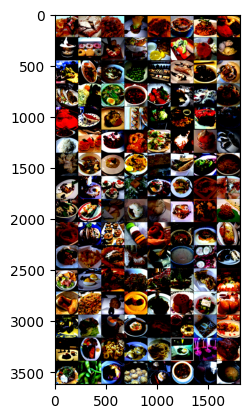

lobster_roll_sandwich beignets spaghetti_carbonara tuna_tartare ravioli french_onion_soup spaghetti_bolognese prime_rib ice_cream donuts tuna_tartare tacos fried_calamari sushi panna_cotta ice_cream guacamole spring_rolls shrimp_and_grits edamame cup_cakes cannoli churros fried_calamari tacos filet_mignon ramen hot_and_sour_soup beet_salad club_sandwich beet_salad shrimp_and_grits apple_pie red_velvet_cake caprese_salad club_sandwich guacamole pork_chop caprese_salad guacamole chicken_curry deviled_eggs strawberry_shortcake donuts tacos chocolate_mousse frozen_yogurt oysters nachos miso_soup risotto paella garlic_bread mussels seaweed_salad french_onion_soup bread_pudding croque_madame falafel greek_salad huevos_rancheros shrimp_and_grits french_onion_soup ravioli pho   spring_rolls cheesecake strawberry_shortcake ice_cream croque_madame gnocchi foie_gras onion_rings tacos foie_gras macarons onion_rings pho   pork_chop lasagna breakfast_burrito macaroni_and_cheese guacamole beignets sa

In [ ]:
#Display new image
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

#Create model (7.0) - Don't execute if loading file from save
Creating the resnet50 based model, using SGD Optimizer and cross entropy loss as the loss function to create a confidence focused model

Using a pre-trained resnet50 model trained on images from imagenet means I don't need to worry about teaching the model about things like shapes

SGD Hyperparameters were tuned according to best performance by other people and from the accuracy tracker found at the top of the notebook

In [ ]:
#create model
from torchvision.models import ResNet50_Weights
model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)

num_features = model.fc.in_features

#Setting this to true will blow up memory usage, DON'T DO IT.
for param in model.parameters():
  param.requires_grad=False

model.fc = nn.Linear(num_features, 102)

#Loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
#optimizer = optim.Adam(model.parameters(), amsgrad=True, lr=0.01, weight_decay=0.0001) #iteration 8.t1
#optimizer = optim.Adadelta(model.parameters(), lr=.01, weight_decay=0.0001) #iteration 8.t2

learn_rate = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3)

#move model to cuda
if torch.cuda.is_available():
    model.cuda()

cur_epochs = 0

#summary(model, input_size=(3, img_size, img_size)) #Uncomment to view model layers & structure

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 86.4MB/s]


Run to view layers of the model

#Training (7.0)
11-16 epochs takes ~2hrs to train <br>
3-4 epochs takes ~30-40 minutes
##Output order:

 - Epoch: Cycles of training
 - Number of data points trained on
 - Loss: How far model is off from regression
 - TSSoE: Time since start of execution

check if grad = None, if so then we've found the

In [ ]:
running_loss = 0.0
model.to(device)

base_time = time.time()
i = 0

#number of times to train the data set also called epochs
train_session_epochs = 10

with torch.enable_grad():
  for epoch in range(train_session_epochs):
    running_loss = 0.0
    cur_epochs = cur_epochs + 1

    for inputs, labels in trainloader:
      i = i+1

      #move to gpu
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero parameter gradients
      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      loss.cuda()
      optimizer.step()

      #print stats
      running_loss += loss.item()
      if i % 592 == 591:
        print(f'[{cur_epochs}, {i + 1:5d} Loss: {running_loss / 591:.5f}, TSSoE: {(time.time()-base_time)/60:.2f}]')
        running_loss = 0.0

print(f"Finished training: {(time.time()-base_time)/60:.2f}, Final loss: {running_loss / 591:.5f}")

[31,   592 Loss: 0.007, TSSoE: 14.70]
[32,  1184 Loss: 0.006, TSSoE: 28.94]
[33,  1776 Loss: 0.004, TSSoE: 42.56]
[34,  2368 Loss: 0.003, TSSoE: 56.23]
[35,  2960 Loss: 0.003, TSSoE: 70.12]
[36,  3552 Loss: 0.002, TSSoE: 83.82]
[37,  4144 Loss: 0.002, TSSoE: 97.48]
[38,  4736 Loss: 0.002, TSSoE: 111.16]
[39,  5328 Loss: 0.002, TSSoE: 124.92]
[40,  5920 Loss: 0.001, TSSoE: 138.63]
Finished training: 138.65, Final loss: 0.00000


# Save model (7.0)
Use this to save the model to a folder called "resnetPIzzer" as a pt and pth file
Dictionary Schema:
- "epoch" - Current epoch the model last finished on
- "model_state_dict" - Model state the last time it was saved
- "optimizer_state_dict" - Optimizer state at the time of last model save

In [ ]:
#Saving files into files for training or testing later
GDRIVEPATH_pth = F"/content/gdrive/MyDrive/resnetPIzzer/pizzerE40SGD01-128MB.pth"
GDRIVEPATH_pt = F"/content/gdrive/MyDrive/resnetPIzzer/pizzerE40SGD01-128MB.pt"

checkpoint_pth = torch.save({
            'epoch': cur_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, GDRIVEPATH_pth)

checkpoint_pt = torch.save({
            'epoch': cur_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, GDRIVEPATH_pt)

#Test Run (7.0-t)

Load data once, then cycle through data set with the second function. At this point, reducing batch size and re-loading to reduce visual clutter is fine, however, you will need to reset the batch size afterwards if you intend to keep training for the sake of consistency

In [ ]:
#Load data into an iteration object
dataiter2 = iter(testLoader)

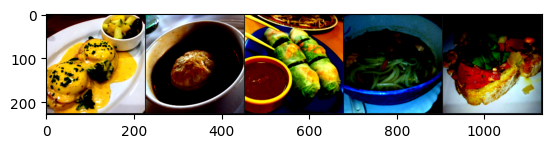

GroundTruth:  eggs_benedict lobster_bisque spring_rolls ramen bruschetta
predicted:  eggs_benedict french_onion_soup spring_rolls pho   bruschetta


In [ ]:
#Go through iteration object to view images and predictions
images2, labels2 = next(dataiter2)

images2.to(device)
labels2.to(device)

imshow(torchvision.utils.make_grid(images2))
print('GroundTruth: ', ' '.join(f'{classes[labels2[j]]:5s}' for j in range(test_batch_size)))

outputs = model(images2.to(device))
_, predicted = torch.max(outputs, 1)

print('predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(test_batch_size)))

#Load model from save for training (7.0)

Load once, refer to *Save model* for information on the schema, this is effecively just setting up the model and unpacking the last state from the file it was saved as so training doesn't need to happen every time.

USE BUILD 1.0 TO RUN E46SGD01-32128M

In [ ]:
#Load checkpoint
CHECKPOINT_PATH = F"/content/gdrive/MyDrive/resnetPIzzer/pizzerE40SGD01-128MB.pt"
checkpoint = torch.load(CHECKPOINT_PATH)

#Set up base model
from torchvision.models import ResNet50_Weights
model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)

optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0001)
#optimizer = optim.Adam(model.parameters(), amsgrad=True, lr=0.002, weight_decay=0.0001) #iteration 8.t1a
#optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=0.0001) #iteration 8.t1b
learn_rate = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 102)

if torch.cuda.is_available():
    model.cuda()

#Set to True for training, set to false for testing
for param in model.parameters():
  param.requires_grad=False

#Load previous states
cur_epochs = checkpoint['epoch']
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.load_state_dict(checkpoint['model_state_dict'])

criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 83.3MB/s]


#Accuracy Checker (7.0)
## Accuracy Overall
Record: ~84% - SGD01-128M

In [ ]:
correct = 0
total = 0

#Set to evaluation mode
model.eval()

#Makes sure the model isn't training on the test data
with torch.no_grad():
  for data in testLoader:

    images, labels = data
    images.to(device)
    labels.to(device)

    outputs = model(images.to(device))

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of network on the {total} images: {(100 * correct / total):5f} %')

Accuracy of network on the 25250 images: 85.259406 %


## Accuracy by class

In [ ]:
correct_prediction = {classname: 0 for classname in classes}
total_prediction = {classname: 0 for classname in classes}

#Set to evaulation mode
model.eval()

with torch.no_grad():
  for data in testLoader:

    images, labels = data
    images.to(device)
    labels.to(device)

    outputs = model(images.to(device))
    _, predictions = torch.max(outputs, 1)

    #collect the correct predictions for each class
    for label, prediction in zip(labels, predictions):
      if label == prediction:
        correct_prediction[classes[label.to(device)]] += 1
      total_prediction[classes[label.to(device)]] += 1

for classname, correct_count in correct_prediction.items():
   if classname != '':
     accuracy = 100 * float(correct_count) / total_prediction[classname]
     print(f'Accuracy for class: {classname:5s} is {accuracy:.2f} %')

Accuracy for class: apple_pie is 63.20 %
Accuracy for class: baby_back_ribs is 87.20 %
Accuracy for class: baklava is 91.20 %
Accuracy for class: beef_carpaccio is 88.80 %
Accuracy for class: beef_tartare is 84.80 %
Accuracy for class: beet_salad is 77.60 %
Accuracy for class: beignets is 90.00 %
Accuracy for class: bibimbap is 92.80 %
Accuracy for class: bread_pudding is 64.80 %
Accuracy for class: breakfast_burrito is 80.00 %
Accuracy for class: bruschetta is 80.00 %
Accuracy for class: caesar_salad is 91.60 %
Accuracy for class: cannoli is 90.80 %
Accuracy for class: caprese_salad is 88.40 %
Accuracy for class: carrot_cake is 85.20 %
Accuracy for class: ceviche is 76.00 %
Accuracy for class: cheesecake is 86.80 %
Accuracy for class: cheese_plate is 73.20 %
Accuracy for class: chicken_curry is 80.00 %
Accuracy for class: chicken_quesadilla is 86.40 %
Accuracy for class: chicken_wings is 89.60 %
Accuracy for class: chocolate_cake is 74.80 %
Accuracy for class: chocolate_mousse is 64.0

#Temp Archives

Old save

In [ ]:
#FOR SAVING OLDER VERSIONS
NEW_PATH2 = F"/content/gdrive/MyDrive/resnetPIzzer/pizzerE46SGD01-32128MB.tar"
NEW_PATH3 = F"/content/gdrive/MyDrive/resnetPIzzer/pizzerE46SGD01-32128MB.pth"
torch.save(model.state_dict(), NEW_PATH2)
torch.save(model.state_dict(), NEW_PATH3)

Old load

In [ ]:
#FOR LOADING OLDER VERSIONS
OLD_PATH = F"/content/gdrive/MyDrive/resnetPIzzer/pizzerE46SGD01-32128MB.pth"

from torchvision.models import ResNet50_Weights
model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)

num_features = model.fc.in_features

for param in model.parameters():
  param.requires_grad=False

model.fc = nn.Linear(num_features, 102)

#Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0001)
learn_rate = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3)

if torch.cuda.is_available():
    model.cuda()

model.load_state_dict(torch.load(OLD_PATH))

<All keys matched successfully>